In [ ]:
# Load the usual suspects:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import pandas as pd

# Fiddle with figure settings here:
plt.rcParams['figure.figsize'] = (15,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
# Set the default colour cycle (in case someone changes it...)
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

# A simple little 2D matrix plotter, excluding x and y labels.
def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)


In [ ]:
class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)


In [ ]:
series = pd.read_csv("weekly-closings-of-the-dowjones-.csv")['Close']
series


0      890.19
1      901.80
2      888.51
3      887.78
4      858.43
        ...  
157    791.77
158    787.23
159    787.94
160    784.57
161    752.58
Name: Close, Length: 162, dtype: float64

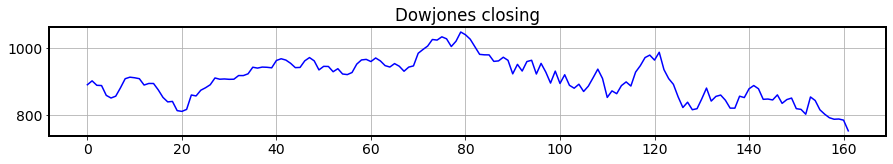

In [ ]:
plt.style.context('bmh')
plt.figure(figsize=(15, 2))   
series.plot(color='blue')
plt.title('Dowjones closing')
plt.grid()


Text(0.5, 1.0, '$L=2$ for the Dowjones closing')

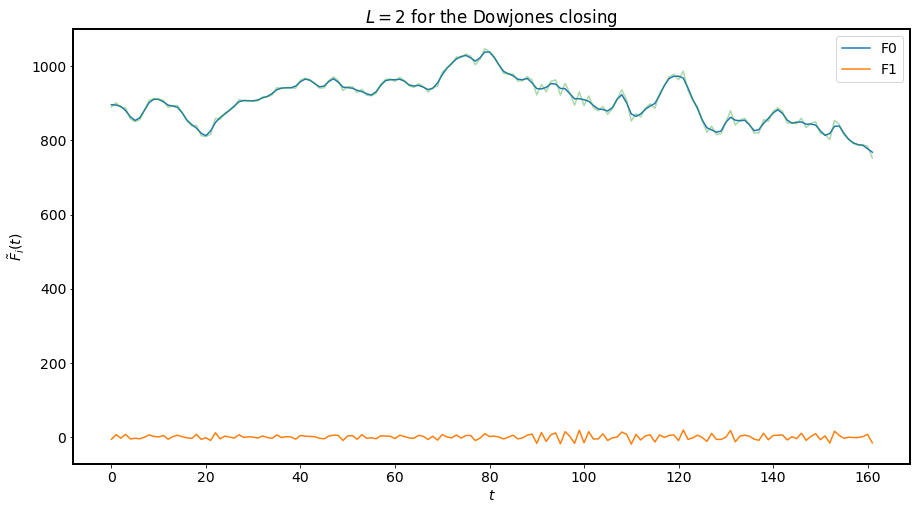

In [ ]:
F_ssa_L2 = SSA(series, 2)
F_ssa_L2.components_to_df().plot()
F_ssa_L2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=2$ for the Dowjones closing")

Text(0.5, 1.0, '$L=5$ for the Dowjones closing')

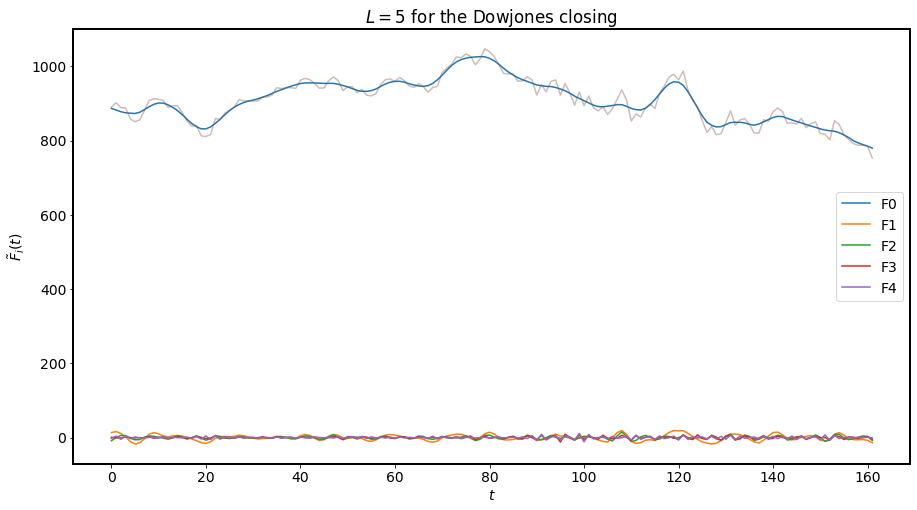

In [ ]:
F_ssa_L5 = SSA(series, 5)
F_ssa_L5.components_to_df().plot()
F_ssa_L5.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=5$ for the Dowjones closing")


Text(0.5, 1.0, '$L=20$ for the Dowjones closing')

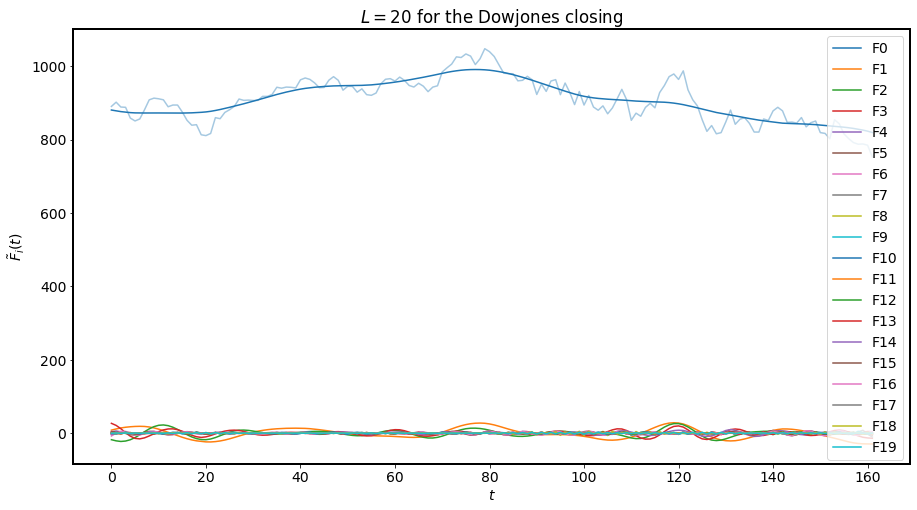

In [ ]:
F_ssa_L20 = SSA(series, 20)
F_ssa_L20.components_to_df().plot()
F_ssa_L20.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=20$ for the Dowjones closing")

Text(0.5, 1.0, '$L=40$ for the Dowjones closing')

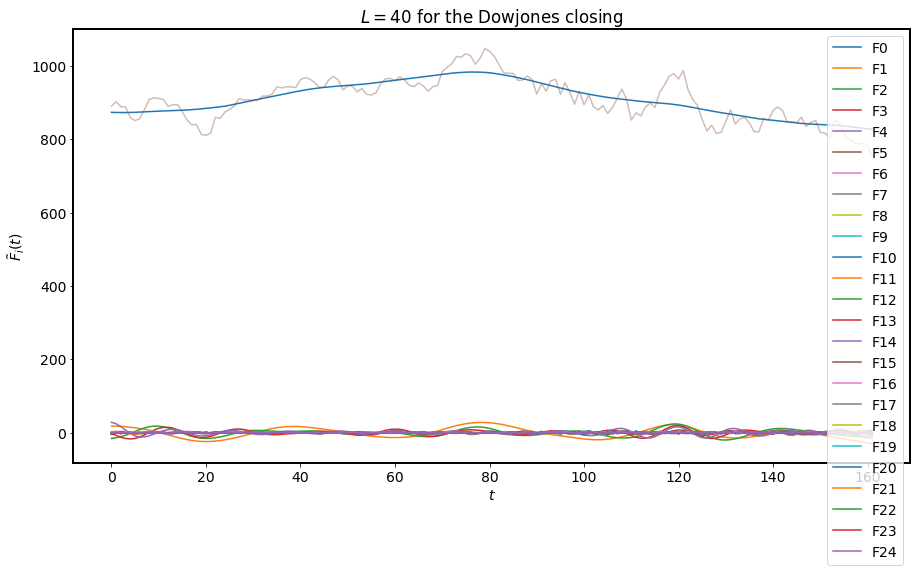

In [ ]:
F_ssa_L40 = SSA(series, 25)
F_ssa_L40.components_to_df().plot()
F_ssa_L40.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=40$ for the Dowjones closing")

w-корреляционная матрица
Длина окна L = 80

In [ ]:
import matplotlib as mpl
mpl.rc('image', cmap='GnBu_r')

Text(0.5, 1.0, 'W-Correlation for the Dowjones closing, $L=80$')

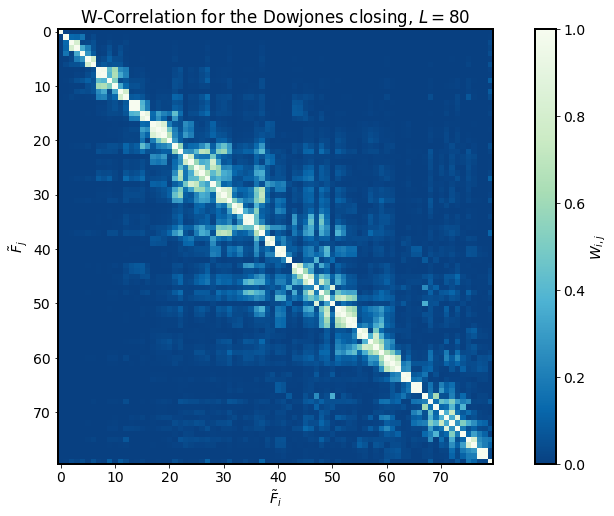

In [ ]:
F_ssa_L80 = SSA(series, 80)

F_ssa_L80.plot_wcorr()
plt.title("W-Correlation for the Dowjones closing, $L=80$")

в корреляционной матрице можно выделить два блока:
F0-F19; F20-F80

можно увеличить блок F0-F20 и сгруппировать признаки

Text(0.5, 1.0, 'W-Correlation for the Dowjones closing, $L=20$')

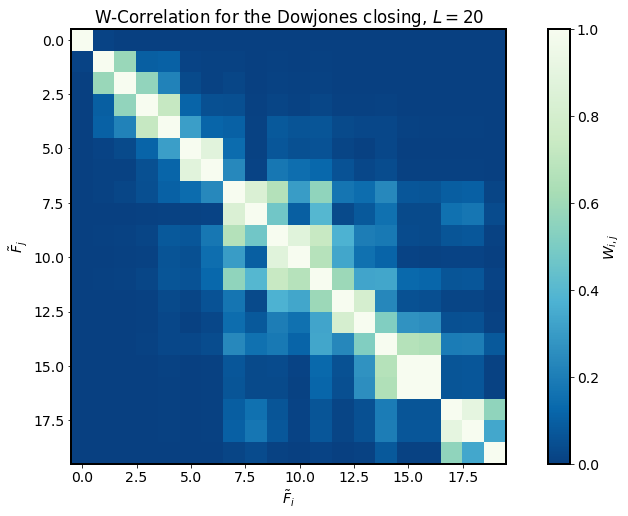

In [ ]:
F_ssa_L20 = SSA(series, 20)
F_ssa_L20.plot_wcorr()
plt.title("W-Correlation for the Dowjones closing, $L=20$")


Объединнение  5 групп:

F0 = [0]

F1 = [1, 2, 3]

F2 = [4, 5, 6]

F3 = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

F4 = [17, 18, 19]

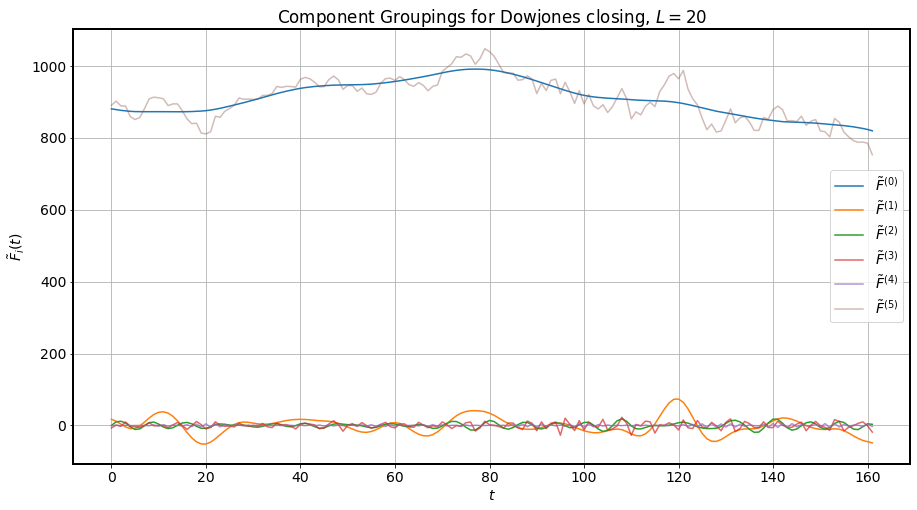

In [ ]:
F_ssa_L20.reconstruct(0).plot()
F_ssa_L20.reconstruct([1,2,3]).plot()
F_ssa_L20.reconstruct([4,5,6]).plot()
F_ssa_L20.reconstruct(slice(7,17)).plot(alpha=0.7)
F_ssa_L20.reconstruct(slice(17,20)).plot(alpha=0.7)
F_ssa_L20.orig_TS.plot(alpha=0.4)
plt.title("Component Groupings for Dowjones closing, $L=20$")
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.legend([r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(6)] + ["Original TS"]);
plt.grid()

 выделение тренда

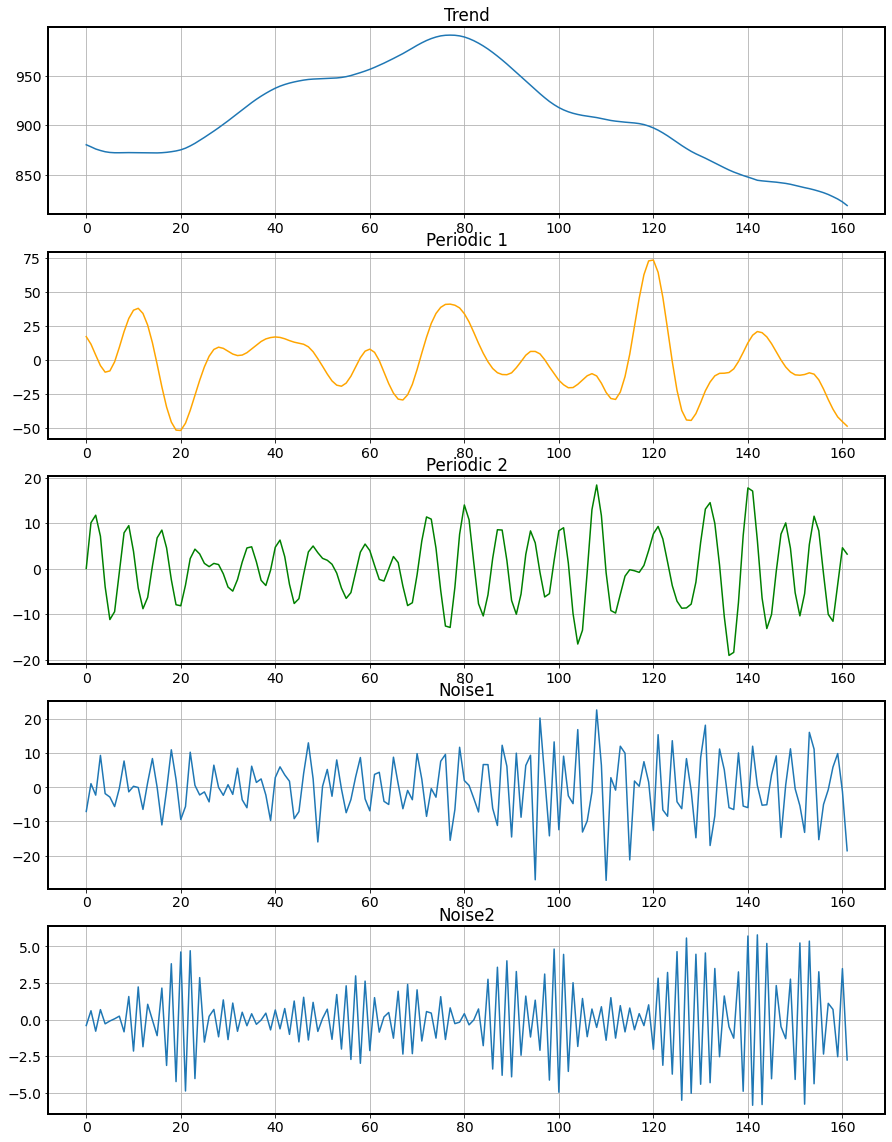

<Figure size 1080x144 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(5, figsize=(15, 20))
plt.figure(figsize=(15, 2))
ax[0].plot(F_ssa_L20.reconstruct(0))
ax[0].set_title('Trend')
ax[0].grid()
ax[1].plot(F_ssa_L20.reconstruct([1,2,3]), c='orange')
ax[1].set_title('Periodic 1')
ax[1].grid()
ax[2].plot(F_ssa_L20.reconstruct([4,5,6]), c='g')
ax[2].set_title('Periodic 2')
ax[2].grid()
ax[3].plot(F_ssa_L20.reconstruct(slice(7,17)))
ax[3].set_title('Noise1')
ax[3].grid()
ax[4].plot(F_ssa_L20.reconstruct(slice(17,20)))
ax[4].set_title('Noise2')
ax[4].grid()


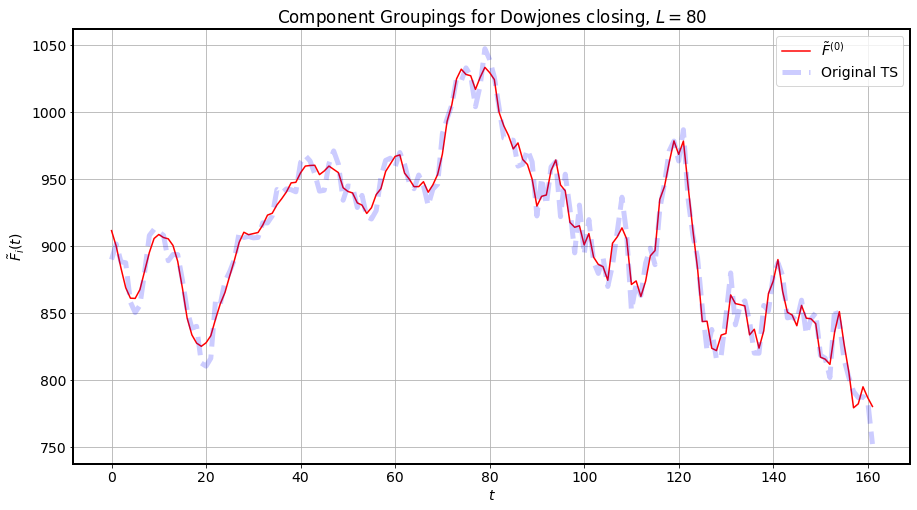

In [ ]:
F_ssa_L80.reconstruct(slice(0, 20)).plot(c= 'red')
F_ssa_L80.orig_TS.plot(c = 'b', alpha=0.2, linestyle='--', linewidth=5)
plt.title("Component Groupings for Dowjones closing, $L=80$")
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.legend([r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(1)] + ["Original TS"])
plt.grid()


для описания ряда достаточно суммы первых 19 компонент

Но вот никак не пойму как получить формулу апроксимирующую ряд в явном виде, чтобы было у = тренд + сезонность1 + сезонность2 и тд. Всех уже наверное замучил, но мне это очень сильно надо(((

Тут просто интереса ради смотрел

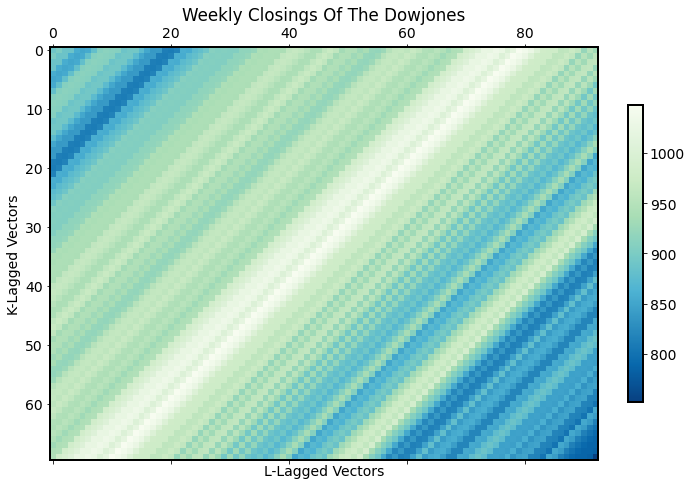

In [ ]:
L = 70 
K = len(series)  - L + 1 
X = np.column_stack([series[i:i+L] for i in range(0,K)])
     


plt.rcParams['figure.figsize'] = (10,8)

ax = plt.matshow(X)
plt.xlabel("L-Lagged Vectors")
plt.ylabel("K-Lagged Vectors")
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("")
plt.title('Weekly Closings Of The Dowjones');



In [ ]:
d = np.linalg.matrix_rank(X) # The intrinsic dimensionality of the trajectory space.

# For those interested in how to code up an SVD calculation, Numerical Recipes in Fortran 77
# has you covered: http://www.aip.de/groups/soe/local/numres/bookfpdf/f2-6.pdf
# Thankfully, we'll leave the actual SVD calculation to NumPy.
U, Sigma, V = np.linalg.svd(X)
V = V.T # Note: the SVD routine returns V^T, not V, so I'll tranpose it back here. This may seem pointless, 
# but I'll treat the Python representation of V consistently with the mathematical notation in this notebook.

# Calculate the elementary matrices of X, storing them in a multidimensional NumPy array.
# This requires calculating sigma_i * U_i * (V_i)^T for each i, or sigma_i * outer_product(U_i, V_i). 
# Note that Sigma is a 1D array of singular values, instead of the full L x K diagonal matrix.
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

# Quick sanity check: the sum of all elementary matrices in X_elm should be equal to X, to within a 
# *very small* tolerance:
if not np.allclose(X, X_elem.sum(axis=0), atol=1e-10):
    print("WARNING: The sum of X's elementary matrices is not equal to X!")

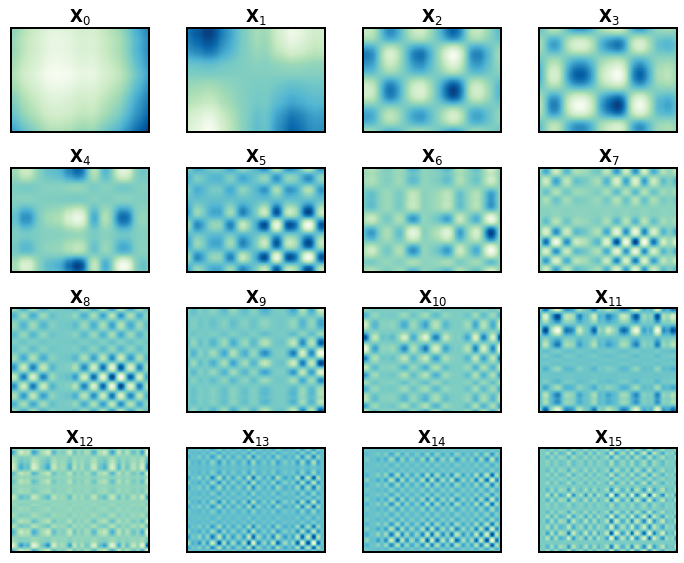

In [ ]:
n = min(16, d) # In case d is less than 12 for the toy series. Say, if we were to exclude the noise component...
for i in range(n):
    plt.subplot(4,4,i+1)
    title = "$\mathbf{X}_{" + str(i) + "}$"
    plot_2d(X_elem[i], title)
plt.tight_layout()

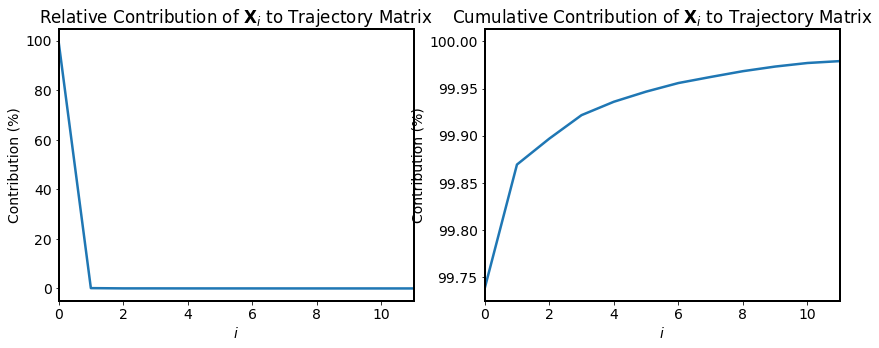

In [ ]:
sigma_sumsq = (Sigma**2).sum()
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(Sigma**2 / sigma_sumsq * 100, lw=2.5)
ax[0].set_xlim(0,11)
ax[0].set_title("Relative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[0].set_xlabel("$i$")
ax[0].set_ylabel("Contribution (%)")
ax[1].plot((Sigma**2).cumsum() / sigma_sumsq * 100, lw=2.5)
ax[1].set_xlim(0,11)
ax[1].set_title("Cumulative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[1].set_xlabel("$i$")
ax[1].set_ylabel("Contribution (%)");


In [ ]:
def Hankelise(X):
    """
    Hankelises the matrix X, returning H(X).
    """
    L, K = X.shape
    transpose = False
    if L > K:
        # The Hankelisation below only works for matrices where L < K.
        # To Hankelise a L > K matrix, first swap L and K and tranpose X.
        # Set flag for HX to be transposed before returning. 
        X = X.T
        L, K = K, L
        transpose = True

    HX = np.zeros((L,K))
    
    # I know this isn't very efficient...
    for m in range(L):
        for n in range(K):
            s = m+n
            if 0 <= s <= L-1:
                for l in range(0,s+1):
                    HX[m,n] += 1/(s+1)*X[l, s-l]    
            elif L <= s <= K-1:
                for l in range(0,L-1):
                    HX[m,n] += 1/(L-1)*X[l, s-l]
            elif K <= s <= K+L-2:
                for l in range(s-K+1,L):
                    HX[m,n] += 1/(K+L-s-1)*X[l, s-l]
    if transpose:
        return HX.T
    else:
        return HX


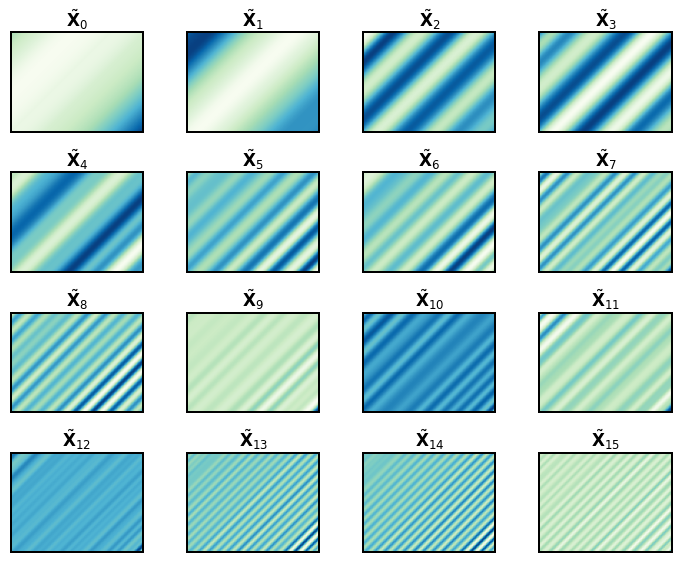

In [ ]:
n = min(d, 16)
for j in range(0,n):
    plt.subplot(4,4,j+1)
    title = r"$\tilde{\mathbf{X}}_{" + str(j) + "}$"
    plot_2d(Hankelise(X_elem[j]), title)
plt.tight_layout() 


Добрый день, спасибо за выполненную работу!
По решению задания всё отлично, зачёт!
Но вот никак не пойму как получить формулу апроксимирующую ряд в явном виде, чтобы было у = тренд + сезонность1 + сезонность2 и тд. Всех уже наверное замучил, но мне это очень сильно надо(((
Это нужно конкретно для этого задания или вообще?
Если по этому заданию, вы ведь берёте компоненты от сса, просто некоторые объединияете.
Если помимо этого задания, можно раскладывать в ряд Фурье, например:
https://medium.com/@khairulomar/deconstructing-time-series-using-fourier-transform-e52dd535a44e
Но стандартно в тренд+сезонность+остаток:
https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/#:~:text=Time%20series%20decomposition%20involves%20thinking,time%20series%20analysis%20and%20forecasting.
Но вообще ваше представление о сезонность1 + сезонность2 + ... может сильно отличаться от того, что понимает под сезонностью1 + сезонностью2 алгоритм. Я понимаю, что вы иметее в виду: годовая сезонность, месячная, недельная, но алгоритм может перемешать эти 3 синусоиды

In [ ]:
data = pd.read_csv("weekly-closings-of-the-dowjones-.csv")['Close']
data

,Week,Close
0,1971-W27,890.19
1,1971-W28,901.80
2,1971-W29,888.51
3,1971-W30,887.78
4,1971-W31,858.43
...,...,...
157,1974-W28,791.77
158,1974-W29,787.23
159,1974-W30,787.94
160,1974-W31,784.57


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data, model='multiplicative')
trend    = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid